In [33]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import copy

In [34]:
## example code of read data
#def load_data(root='data\CroppedYaleB', reduce=4):
def load_data(root='data\ORL', reduce=4):
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            if not fname.endswith('.pgm'):
                continue
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') 
            #on Yale dataset, I reduced the image by 4 times because the image is too large,but for ORL, I did not do it.
            #img = img.resize([s//reduce for s in img.size])
            img = np.asarray(img)
            images.append(img)
            labels.append(i)

    return images, labels


In [35]:
images, labels = load_data()

In [36]:
#channel,H,W
np.asarray(images).shape

(400, 112, 92)

In [37]:
def gaus_noise(imgs, means, sigma, num):
    img_copy = copy.deepcopy(imgs) 
    if len(np.asarray(img_copy).shape) != 3:
        img_copy = np.asarray(img_copy).reshape(img_copy.shape[1], np.asarray(images).shape[1], np.asarray(images).shape[2])
    for i in range(len(img_copy)):
        noise_num = int(num * img_copy[i].shape[0] * img_copy[i].shape[1])
        for j in range(noise_num):
            randX = random.randint(0, img_copy[i].shape[0] - 1)
            randY = random.randint(0, img_copy[i].shape[1] - 1)
            img_copy[i][randX, randY] = img_copy[i][randX, randY] + random.gauss(means, sigma=sigma)
            if img_copy[i][randX, randY] < 0:
                img_copy[i][randX, randY] = 0
            if img_copy[i][randX, randY]> 255:
                img_copy[i][randX, randY] = 255
        
    return img_copy

In [38]:
img_gaus  = gaus_noise(images,100,50,1e-1)

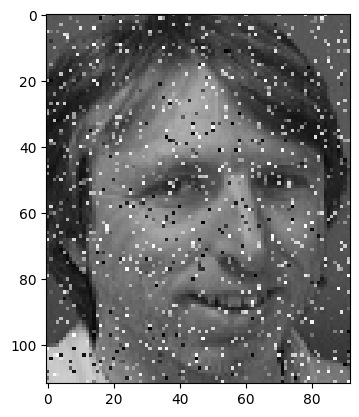

In [39]:
plt.imshow(img_gaus[328],cmap='gist_gray')

In [40]:
def salt_noise(imgs, per):
    img_copy = copy.deepcopy(imgs)
    
    if len(np.asarray(img_copy).shape) != 3:
        img_copy = np.asarray(img_copy).reshape(img_copy.shape[1], np.asarray(images).shape[1], np.asarray(images).shape[2])
  
    for i in range(len(img_copy)):
        noise_num = int(per * img_copy[i].shape[0] * img_copy[i].shape[1])
        for j in range(noise_num):
            randx = np.random.randint(0, img_copy[i].shape[0] - 1)
            randy = np.random.randint(0, img_copy[i].shape[1] - 1)
            if random.random() < 0.5:
                img_copy[i][randx, randy] = 0
            else:
                img_copy[i][randx, randy] = 255
    
    return img_copy

In [41]:
img_salt  = salt_noise(images,0.1)

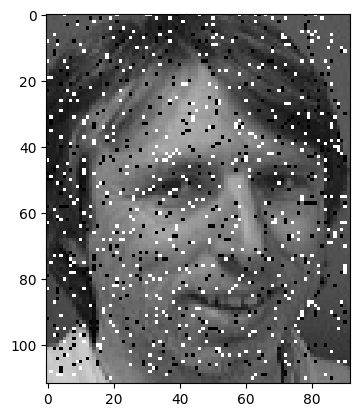

In [42]:
plt.imshow(img_salt[328],cmap='gist_gray')

In [43]:
def block_noise(imgs, b):
    img_copy = copy.deepcopy(imgs)
    
    if len(np.asarray(img_copy).shape) != 3:
        img_copy = np.asarray(img_copy).reshape(img_copy.shape[1], np.asarray(images).shape[1], np.asarray(images).shape[2])
  
    for i in range(len(img_copy)):

        randx = np.random.randint(0, img_copy[i].shape[0] - b)
        randy = np.random.randint(0, img_copy[i].shape[1] - b)
        for j in range(b):
            for w in range(b):
                img_copy[i][randx+j][randy+w] = 255

    return img_copy

In [44]:
img_bloack  = block_noise(images,10)

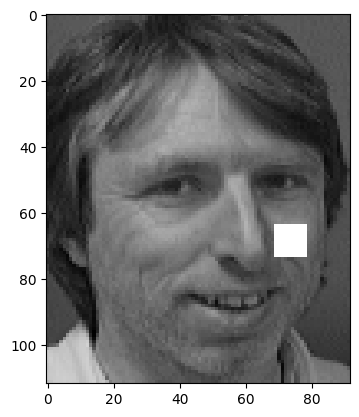

In [45]:
plt.imshow(img_bloack[328],cmap='gist_gray')

In [46]:
def lecture_NMF(X_train,rank,max_time = 1000,loss_exp=1e-3):
    #|| X - DR ||F2 F we use L2 norm
    D = np.random.random((X_train.shape[0],rank))
    R = np.random.random((rank,X_train.shape[1])) 
    # updating D and R
    loss = 1
    i = 0
    while loss>=loss_exp and  i<=max_time:
        R = R*(D.T.dot(X_train)/D.T.dot(D).dot(R)) 
        D = D*(X_train.dot(R.T)/D.dot(R).dot(R.T))
        loss = np.linalg.norm(X_train-D.dot(R)) ** 2
        i+=1
    return D,R,loss 

In [47]:
def test_data(imgs,lab,divided=0.7):
    imgs = np.array(imgs).transpose(1,2,0)
    imgs = np.concatenate(imgs,axis=0)
    train_size = int(imgs.shape[1]*divided)
    train_data = np.vstack((imgs,labels))
    #train_data = np.row_stack((imgs,lab))
    train_data = np.random.permutation(train_data.T)[0:train_size].T
    X_tr = train_data[:-1]
    Y_tr = train_data[-1]
    return X_tr,Y_tr

In [48]:
or_x_set=[]
or_y_set=[]
guas_set = []
salt_set = []
block_set = []
for i in range(5):
    X_set_or,Y_set_or = test_data(images,labels,0.8)
    or_x_set.append(X_set_or)
    or_y_set.append(Y_set_or)
    
    guas_set_d = gaus_noise(X_set_or, 100,50,1e-5).transpose(1,2,0)
    guas_set_d = np.concatenate(guas_set_d,axis=0)
    guas_set.append(guas_set_d)
    
    salt_set_d = salt_noise(X_set_or,0.1).transpose(1,2,0)
    salt_set_d = np.concatenate(salt_set_d,axis=0)
    salt_set.append(salt_set_d)
    
    block_set_d = block_noise(X_set_or,10).transpose(1,2,0)
    block_set_d = np.concatenate(block_set_d,axis=0)
    block_set.append(block_set_d)
    

In [49]:
def train(train_data,rank):
    D_set = []
    R_set = []
    for i in range(len(train_data)):
        D,R,loss = lecture_NMF(train_data[i],rank)
        print(f'this is the {i+1} times, {loss}')
        D_set.append(D)
        R_set.append(R)
    return D_set,R_set

In [50]:
rank = 40
D_salt,R_salt = train(salt_set,rank)

this is the 1 times, 7173530129.557041
this is the 2 times, 7175125078.180476
this is the 3 times, 7184665412.278932
this is the 4 times, 7168084934.653055
this is the 5 times, 7130942169.36922


In [51]:
D_guas,R_guas = train(guas_set,rank)

this is the 1 times, 2433630985.09612
this is the 2 times, 2442572485.9370146
this is the 3 times, 2440024472.3948283
this is the 4 times, 2474684658.0080185
this is the 5 times, 2396107557.699189


In [52]:
D_block,R_block = train(block_set,rank)

this is the 1 times, 3024673795.0103827
this is the 2 times, 3010941490.346612
this is the 3 times, 3024394810.221666
this is the 4 times, 3054907024.8195043
this is the 5 times, 2965845015.3860927


In [53]:
def RRE(clean,R,D,name):
    rre = []
    for i in range(5):
        R_n = R[i]
        D_n = D[i]
        error = np.linalg.norm(clean-D_n.dot(R_n))/np.linalg.norm(clean)
        rre.append(error)
    print(f' the rre of {name} is {sum(rre)/len(rre)}')

In [54]:
RRE(or_x_set,R_salt,D_salt,'salt noise')

 the rre of salt noise is 0.5153289154187529


In [55]:
RRE(or_x_set,R_guas,D_guas,'guas noise')


 the rre of guas noise is 0.521908388317835


In [56]:
RRE(or_x_set,R_block,D_block,'block noise')

 the rre of block noise is 0.520183960379459
